In [2]:
import pandas as pd
import numpy as np

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers

# Load libriaries and functions.
from tensorflow import keras
tfk = tf.keras
tf.keras.backend.set_floatx("float32")
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers 
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, InputLayer, Dropout

import matplotlib.pyplot as plt
from scipy import stats
from patsy import dmatrices # helps format the input and target variables for ML

from statistics import mean

# import specific functions from the machine learning library, "sklearn"
from sklearn.model_selection import RepeatedKFold, ShuffleSplit, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from scipy.stats import norm, gaussian_kde
from sklearn.neighbors import KernelDensity

import warnings
warnings.filterwarnings('ignore')

# import seaborn as sns
# sns.set_style("darkgrid")

In [3]:
# read data from the .csv file

df = pd.read_csv("am_measurement_data.csv")
df.head()

,print_serial,design,print_location,hardware,layout,material,color,feature_category,feature_class,feature_id,feature_category_class,material_color,part_id,print_x_mm,print_y_mm,CAD_mm,measure_mm,DFT_mm,print_dist_from_origin_mm,thermal_cure
0,KR70035C,bracket,7,1,1,EPX,black,center,dist_length,bracket_dist_mm_c,center_dist_length,EPX_black,KR70035C_7,42,48,15.0,14.969881,-0.030119,63.780875,True
1,KR70035C,bracket,7,1,1,EPX,black,height,height,bracket_height_mm,height_height,EPX_black,KR70035C_7,42,48,8.0,7.644579,-0.355421,63.780875,True
2,KR70035C,bracket,7,1,1,EPX,black,inner,dia,bracket_inner_dia_mm_a,inner_dia,EPX_black,KR70035C_7,42,48,2.5,2.404393,-0.095607,63.780875,True
3,KR70035C,bracket,7,1,1,EPX,black,inner,length,bracket_inner_length_mm_b,inner_length,EPX_black,KR70035C_7,42,48,15.0,14.928239,-0.071761,63.780875,True
4,KR70035C,bracket,7,1,1,EPX,black,outer,thick,bracket_thick_mm_a,outer_thick,EPX_black,KR70035C_7,42,48,2.0,1.995835,-0.004165,63.780875,True


In [4]:
# Define the target (y) variable and the input (x) variables
# Notice "dmatrices" one-hot-encodes categorical variables for us 

y, x = dmatrices('DFT_mm ~ CAD_mm + print_x_mm + print_y_mm + print_dist_from_origin_mm + C(material) + C(hardware) + C(feature_category) + C(feature_class)', df, return_type="dataframe")
y = y.astype(float)
x = x.astype(float)
y.head()    # target variable to be predicted

,DFT_mm
0,-0.030119
1,-0.355421
2,-0.095607
3,-0.071761
4,-0.004165


In [5]:
# set aside 20% of train and test data for evaluation
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle = True, random_state = 2022)

# Use the same function above for the validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, shuffle=True, random_state= 2022) # 0.25 x 0.8 = 0.2


print("x_train shape: {}".format(x_train.shape))
print("x_test shape: {}".format(x_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("x_val shape: {}".format(x_val.shape))
print("y val shape: {}".format(y_val.shape))

x_train shape: (1215, 16)
x_test shape: (405, 16)
y_train shape: (1215, 1)
y_test shape: (405, 1)
x_val shape: (405, 16)
y val shape: (405, 1)


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
sc = StandardScaler()
mc = MinMaxScaler()
x_train = sc.fit_transform(x_train).astype("float32")
x_val = sc.transform(x_val).astype("float32")
x_test = sc.transform(x_test).astype("float32")

## Build and compile the probabilistic NN model ## 

In [7]:
# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [9]:
train_size = len(x_train)

inputs = keras.Input(shape=(16,))
inputs = layers.BatchNormalization()(inputs)

# Create hidden layers with weight uncertainty using the DenseVariational layer.

densevar = tfp.layers.DenseVariational(
            units=8,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="sigmoid")(inputs)
            
# Create a probabilistic output (Normal distribution), and use the `Dense` layer
# to produce the parameters of the distribution.
# We set units=2 to learn both the mean and the variance of the Normal distribution.

distribution_params = layers.Dense(units=2)(densevar)
outputs = tfp.layers.IndependentNormal(1)(distribution_params)

model_pbnn = keras.Model(inputs=inputs, outputs=outputs)

def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

# Compile model.
model_pbnn.compile(optimizer=tf.optimizers.RMSprop(learning_rate=0.001), loss=negative_loglikelihood, metrics=[keras.metrics.RootMeanSquaredError()])

In [10]:
model_pbnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_variational_1 (Dense  (None, 8)                 9452      
 Variational)                                                    
                                                                 
 dense_1 (Dense)             (None, 2)                 18        
                                                                 
 independent_normal_1 (Inde  ((None, 1),               0         
 pendentNormal)               (None, 1))                         
                                                                 
Total params: 9470 (36.99 KB)
Trainable params: 9470 (36.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Using the 80:20 split ##

In [1]:
# checkpoint_path = "saved_models/cp_pbnn_gpu_80.ckpt" # Using the 80:20 split

checkpoint_path = "saved_models/cp_pbnn_gpu_80.ckpt" # Using the 80:20 split

# Model evaluation using the saved weights from checkpoints after loading

# Loads the weights
model_pbnn.load_weights(checkpoint_path)

print("Evaluating BNN model performance after loading weights from checkpoints...")

_, rmse = model_pbnn.evaluate(x_train, y_train, verbose=0)
print(f"Train RMSE: {round(rmse, 3)}")

_, rmse = model_pbnn.evaluate(x_test, y_test, verbose=0)
print(f"Test RMSE: {round(rmse, 3)}")

## Quantification of Aleatoric and Epistemic Uncertainty ##

In [13]:
mean_preds_au=model_pbnn(x_test).mean().numpy()
std_preds_au=model_pbnn(x_test).stddev().numpy()

mean_preds_au = np.array(mean_preds_au).reshape(1, 405*1)

std_preds_au = np.array(std_preds_au).reshape(1, 405*1)
aleatoric_uncertainty = np.mean(std_preds_au)

N_ITERS = 200

mean_preds_eu = []
std_preds_eu = []

for _ in range(N_ITERS):
    
    mean_preds_eu.append(model_pbnn(x_test).mean().numpy())
    std_preds_eu.append(model_pbnn(x_test).stddev().numpy())
    

mean_preds_eu = np.array(mean_preds_eu).reshape(N_ITERS, 405*1)
avg_mean_preds_eu = np.mean(mean_preds_eu, axis=0)
epistemic_uncertainty = np.std(mean_preds_eu, axis=0) # Epistemic Uncertainty

std_preds_eu = np.array(std_preds_eu).reshape(N_ITERS, 405*1)
avg_std_preds_eu = np.mean(std_preds_eu, axis=0)

aleatoric_uncertainty = np.mean(avg_std_preds_eu) # Aleatoric Uncertainty

In [15]:
np.mean(epistemic_uncertainty)

0.020688059

In [16]:
np.mean(aleatoric_uncertainty)

0.063966766

## Code for plotting results --> We took 50 testing samples ##

In [20]:
y_test = np.array(y_test).flatten()
y_train = np.array(y_train).flatten()
# std_preds_au = np.array(aleatoric_uncertainty).flatten()
# std_preds_eu = np.array(epistemic_uncertainty).flatten()

In [106]:
# type(y_test)
# y_test.flatten().shape
y_train.flatten().shape

(162,)

In [108]:
samples = 50
prediction_test = []
actual_test = []
aleatoric_CI = []
epistemic_CI = []

for idx in range(samples):
    prediction_test.append(round(avg_mean_preds_eu[idx], 4))
    actual_test.append(round(y_test[idx], 4))
    aleatoric_CI.append(round(avg_std_preds_eu[idx], 4))
    epistemic_CI.append(round(epistemic_uncertainty[idx], 4))

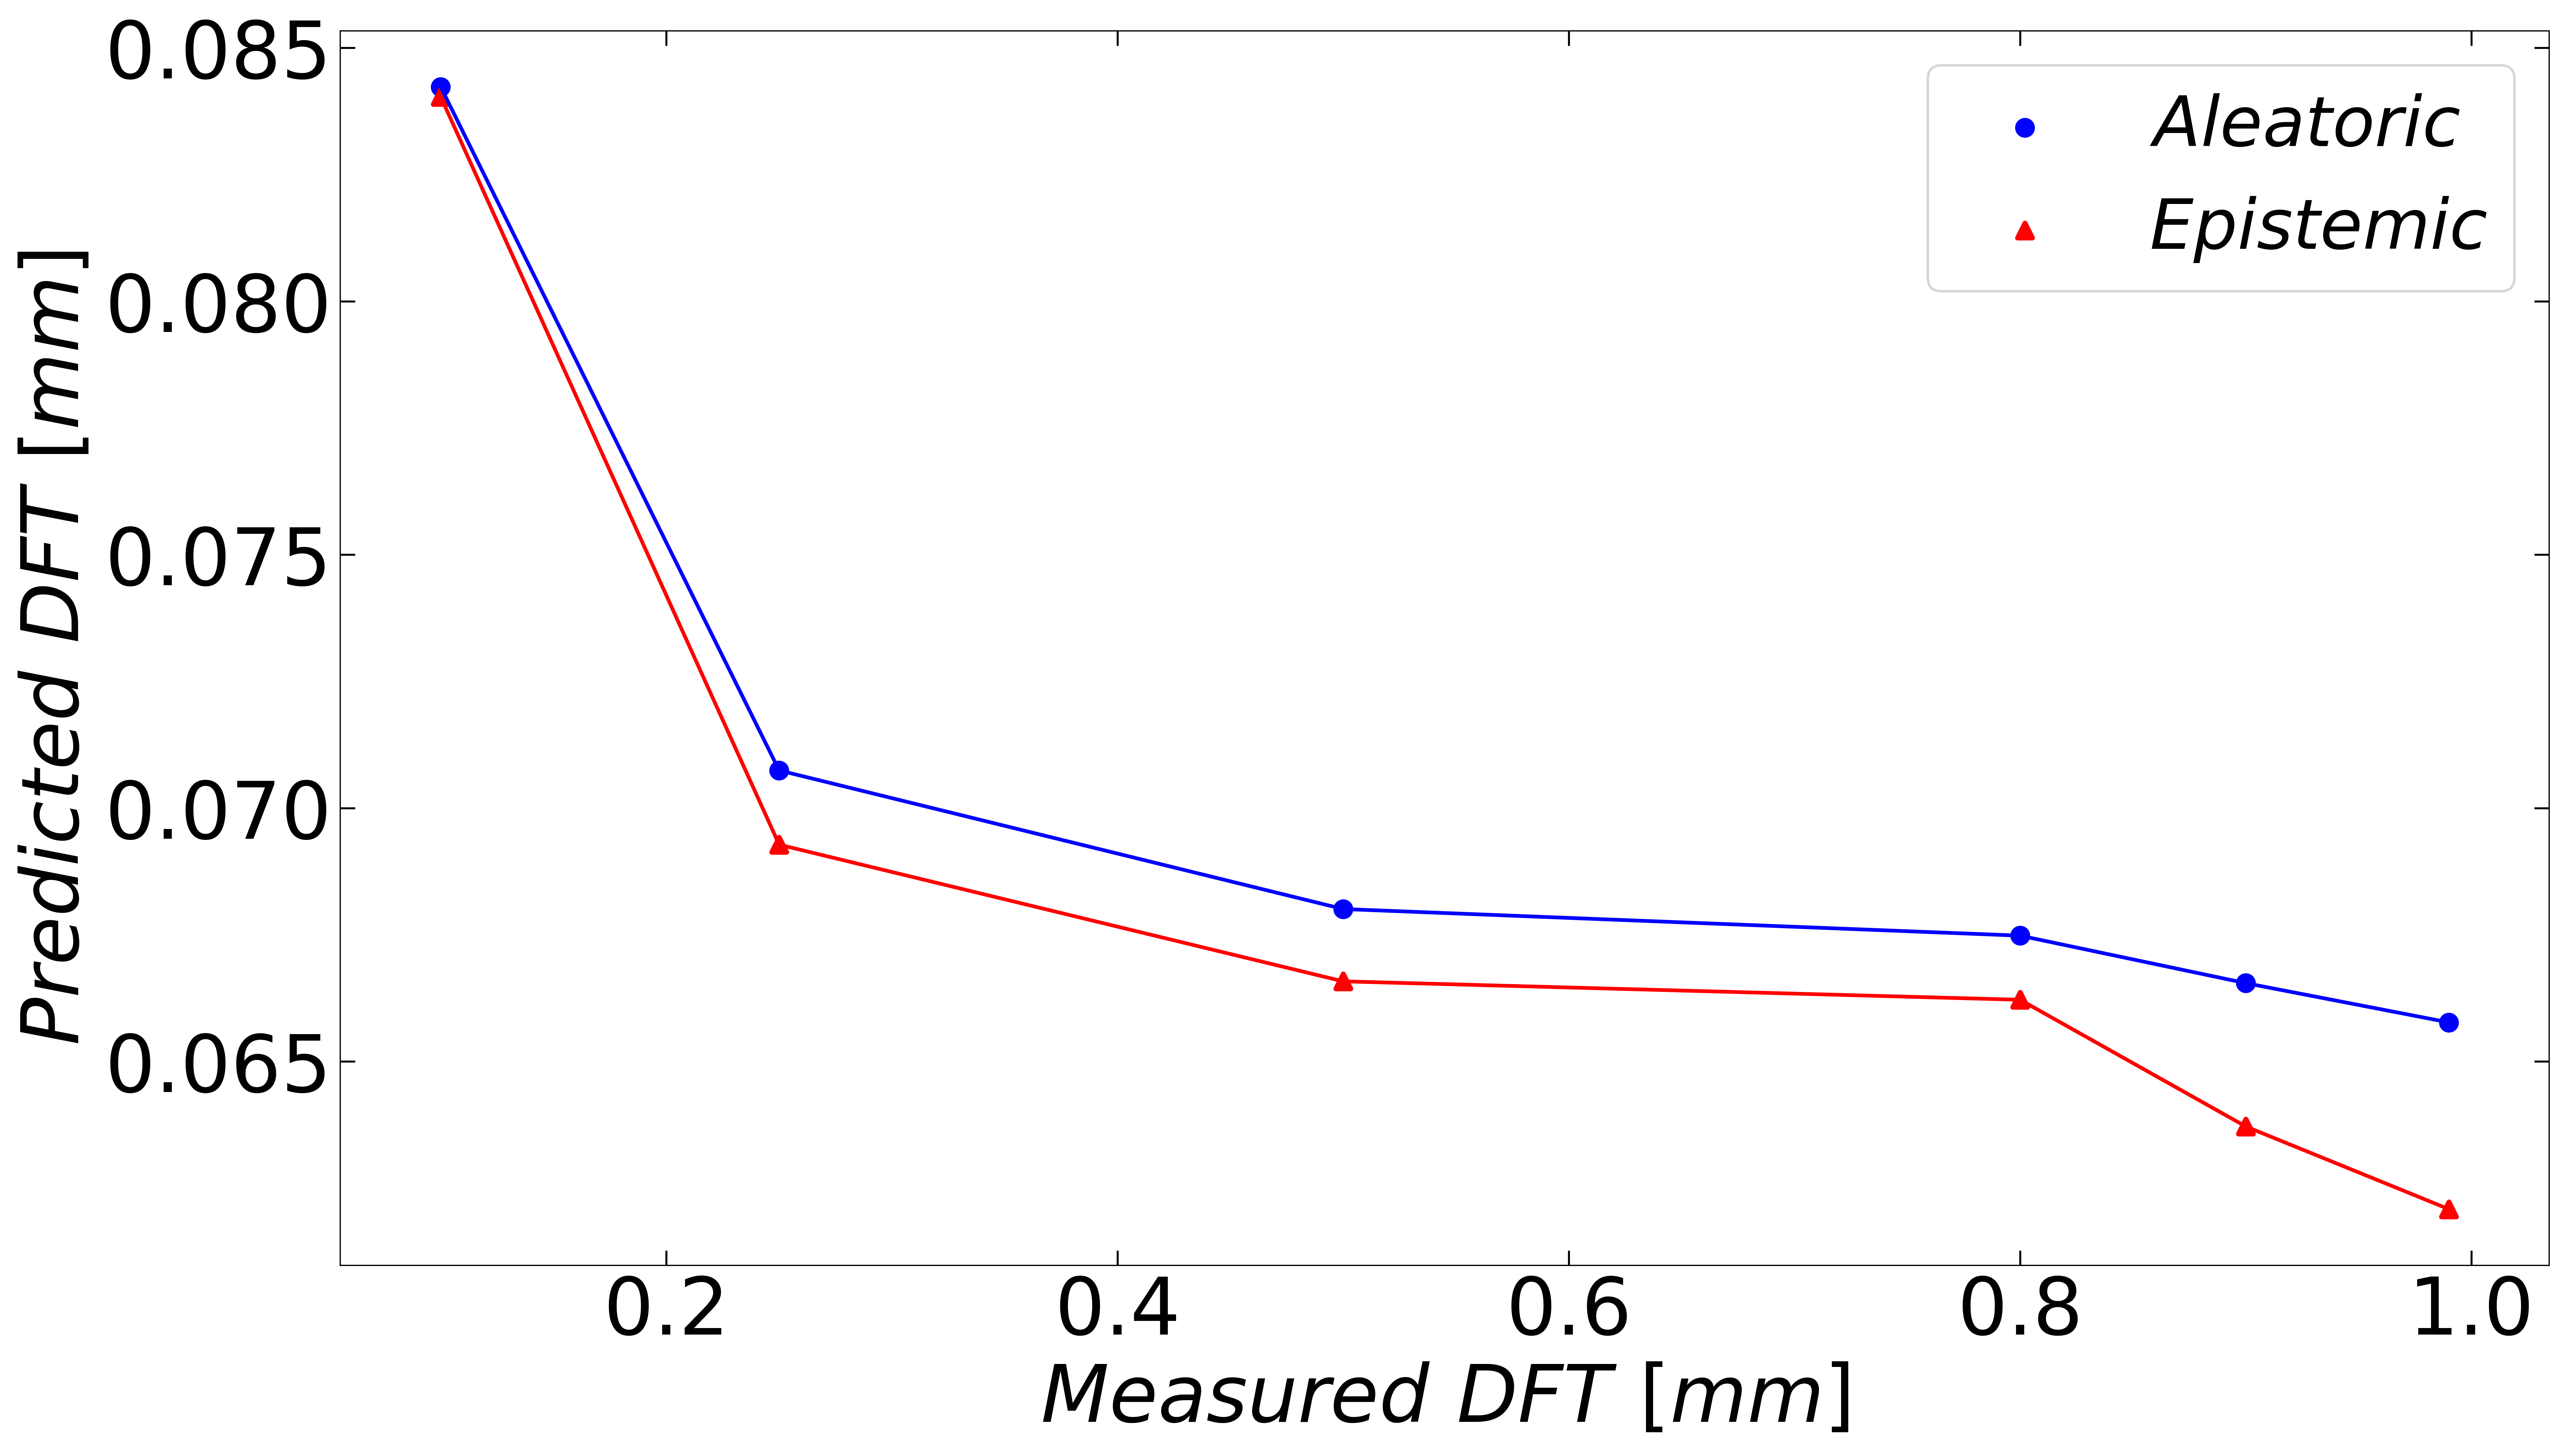

In [17]:
from matplotlib import rc
from matplotlib import rcParams

fontsize = 32
plt.rcParams['axes.linewidth'] = 0.5
rc('text', usetex=False)
rc('xtick', labelsize=fontsize) 
rc('ytick', labelsize=fontsize) 
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 6
rcParams['ytick.major.size'] = 6
rcParams['xtick.minor.size'] = 3.5
rcParams['ytick.minor.size'] = 3.5

fig, ((ax)) = plt.subplots(ncols=1, nrows=1, figsize=(16,9), dpi=600)

fontsize = 32
plt.rcParams['axes.linewidth'] = 0.5
rc('text', usetex=False)
rc('xtick', labelsize=fontsize) 
rc('ytick', labelsize=fontsize) 
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 6
rcParams['ytick.major.size'] = 6
rcParams['xtick.minor.size'] = 3.5
rcParams['ytick.minor.size'] = 3.5

#########################----------------------------------------------------------------------------------------------------------------------------
# Values for Uncertainties (using 200 iterations to quantify epistemic uncertainty)

# 99% Train --> Aleatoric: 0.06327263     Epistemic:0.06208826
# 90% Train --> Aleatoric: 0.06654737     Epistemic:0.06371929
# 80% Train --> Aleatoric: 0.06748427     Epistemic:0.06621919
# 50% Train --> Aleatoric: 0.06800928     Epistemic:0.06658259
# 25% Train --> Aleatoric: 0.07074484     Epistemic:0.06927986
# 10% Train --> Aleatoric: 0.08423194     Epistemic:0.08403626

sf = [0.1, 0.25, 0.5, 0.8, 0.9, 0.99]

std_aleatoric = [0.08423194, 0.07074484, 0.06800928, 0.06748427, 0.06654737, 0.06577263]

std_epistemic = [0.08403626, 0.06927986, 0.06658259, 0.06621919, 0.06371929, 0.06208826]

ax.scatter(sf, std_aleatoric,  marker='o', color='blue', linewidth=2, label='$Aleatoric$')
plt.plot(sf, std_aleatoric, linestyle='solid', color='blue')

ax.scatter(sf, std_epistemic, marker='^', color='red', linewidth=2, label='$Epistemic$')
plt.plot(sf, std_epistemic, linestyle='solid', color='red')

## ---------------------------------------------------------------------------------------------------------------------------------------------------
# test_rmse = [0.122, 0.109, 0.103, 0.101]
# test_rmse_mcd = [0.129, 0.110, 0.101, 0.098]
# sf = [0.1, 0.25, 0.5, 0.8]

# std_aleatoric_pbnn = [0.094, 0.0748, 0.0712, 0.068]
# var_epistemic_pbnn = [0.0093, 0.0064, 0.0057, 0.0053]

# std_aleatoric_mcd = [0.06002, 0.05521, 0.05408, 0.0538]
# var_epistemic_mcd = [0.00369, 0.00313, 0.00299, 0.00296]

# # std_aleatoric = [float(x) for x in std_aleatoric] 

# ax.scatter(sf, std_aleatoric_pbnn,  marker='o', color='blue', linewidth=2, label='$PBNN$')
# plt.plot(sf, std_aleatoric_pbnn, linestyle='--', color='blue')
# ax.errorbar(sf, test_rmse, yerr = std_aleatoric, fmt="o", alpha=0.8, capsize=4, label='Aleatoric Uncertainty $PBNN$')
# ax.errorbar(sf, test_rmse, yerr = var_epistemic, fmt="o", alpha=0.3, capsize=4, label='Epistemic Uncertainty $PBNN$')

# ax.scatter(sf, std_aleatoric_mcd, marker='o', color='red', linewidth=2, label='$MCD$')
# plt.plot(sf, std_aleatoric_mcd, linestyle='--', color='red')
# # ax.errorbar(sf, test_rmse_mcd, yerr = std_aleatoric_mcd, fmt="^", color='lime', alpha=0.5, capsize=4, label='Aleatoric Uncertainty $MCD$')
# # ax.errorbar(sf, test_rmse_mcd, yerr = var_epistemic_mcd, fmt="^", color='navy', alpha=0.3, capsize=4, label='Epistemic Uncertainty $MCD$')

# # plt.plot(sf, test_rmse, linestyle='dashed', linewidth=2)
# # plt.fill_between(np.array(sf), np.array(test_rmse), test_rmse + 1.96*np.array(std_aleatoric), test_rmse - 1.96*np.array(std_aleatoric), alpha=0.1, 
# #                  color='navy', label='Aleatoric Uncertainty')
# # plt.fill_between(sf, test_rmse, test_rmse + 1.96*var_epistemic, test_rmse - 1.96*var_epistemic, alpha=0.2, 
# #                  color='crimson', label='Epistemic Uncertainty')
## -----------------------------------------------------------------------------------------------------------------------------------------------------

# Parity plot for PBNN (quantification of both aleatoric and epistemic uncertainty)

# ax.set_ylim(-0.5, 0.5)
# ax.set_xlim(-0.5, 0.5)

# # 1:1 line for perfect predictions
# x0, x1 = ax.get_xlim()
# y0, y1 = ax.get_ylim()
# lims = [max(x0, y0), min(x1, y1)]
# ax.plot(lims, lims, '--k', linewidth=5, alpha=0.2)

# ax.scatter(np.array(actual_test),np.array(prediction_test), s=60, facecolors='none', edgecolors='b', alpha=0.6, label='Mean Predictions')
# # ax.errorbar(np.array(actual_test), np.array(prediction_test), yerr=aleatoric_CI, fmt='none', color='red', alpha=0.5, capsize=5, label='Aleatoric')
# ax.errorbar(np.array(actual_test), np.array(prediction_test), yerr=epistemic_CI, fmt='none', color='black', alpha=0.7, capsize=5, label='Epistemic')

#-------------------- Line Plot for mean prediction and actual using PBNN -------------------------------------------------------------------------------

# x_grid = np.linspace(0, 49, 50)

# ax.plot(prediction_test[0:50], linestyle='solid', alpha=0.8, color='black', linewidth=2, label='Mean Prediction')
# ax.plot(actual_test[0:50], linestyle='dashed', alpha=0.8, color='black', linewidth=2, label='Actual')
# ax.fill_between(x_grid, prediction_test[0:50] + 1.96*np.array(aleatoric_CI[0:50]), prediction_test[0:50] - 1.96*np.array(aleatoric_CI[0:50]), alpha=0.2, 
#                  color='gray', label='Aleatoric')
# ax.fill_between(x_grid, prediction_test[0:50] + 1.96*np.array(epistemic_CI[0:50]), prediction_test[0:50] - 1.96*np.array(epistemic_CI[0:50]), alpha=0.4, 
#                  color='gray', label='Epistemic')

# # pos = ax.get_position()
# # ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])
# # ax.legend(
# #     loc='upper center', 
# #     bbox_to_anchor=(3.5, 2),
# #     ncol=3, 
# # )

# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fontsize=28)

# # Shrink current axis's height by 10% on the bottom
# box = ax.get_position()
# ax.set_position([box.x0, box.y0 + box.height * 0.1,
#                  box.width, box.height * 0.9])

# # Put a legend below current axis
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5)

#----------------------------------------------------------------------------------------------------------------------------------------------------

# ax.set_ylabel(r'$Aleatoric$ $Uncertainty$ $[µm]$', fontweight ='bold', fontsize=fontsize)
# ax.set_xlabel(r'$Sampling$ $Fraction$ (% $Train$)', fontweight ='bold', fontsize=fontsize)

# ax.set_ylabel(r'$Uncertainty$ $[mm]$', fontweight ='bold', fontsize=fontsize)
# ax.set_xlabel(r'$Sampling$ $Fraction$ (% $Train$)', fontweight ='bold', fontsize=fontsize)

# ax.set_ylabel(r'$DFT$ $Values$ $[mm]$', fontweight ='bold', fontsize=fontsize)
# ax.set_xlabel(r'$No.$ $of$ $Testing$ $Samples$', fontweight ='bold', fontsize=fontsize)

ax.set_ylabel(r'$Predicted$ $DFT$ $[mm]$', fontweight ='bold', fontsize=fontsize)
ax.set_xlabel(r'$Measured$ $DFT$ $[mm]$', fontweight ='bold', fontsize=fontsize)

# ax.set_xlim([-0.05,1.1])
# ax.set_ylim([0.05,0.1])
ax.tick_params(left = True, right = True, top= True, bottom= True, which = 'both')
# plt.xticks(np.arange(0, 1.1, step=0.1))
ax.legend(loc='best', fontsize=28)
# plt.savefig("Plots/Parity_plot_UQ_PBNN_10.png")
# ax.show()

# plt.legend(loc='upper right', fontsize = 20)
plt.show()